In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Give values to measured units
mV = 1e-3
nF = 1e-9
ms = 1e-3
nA = 1e-9

MOhm = 1e6

### Basic ring model
In this model, we construct a host of LIF neurons and synapse them as in a ring-attractor. The neurons are networked using a 'connect_with_fixed_points' function. While this function is currently coded to represent a ring-attractor type network, changing this function is enough to construct a many different types of neural interactions.

In a typical LIF model, a neuron receives inputs through excitatory and inhibitory synapses. Excitatory synapses depolarize the membrane potential of the neuron and cause it to fire action potentials more easily, while inhibitory synapses hyperpolarize the membrane potential of the neuron and make it harder for the neuron to fire action potentials. The reversal potential refers to the membrane potential that the synapse maintains when it is in equilibrium.

In the LIFNeuron class, $Vsyn_{ex}$ and $Vsyn_{in}$ represent the reversal potentials for excitatory and inhibitory synapses respectively. When a neuron receives an excitatory input, the $Vsyn_{ex}$ parameter represents the potential it will drive the neuron to, and similarly when a neuron receives an inhibitory input, the $Vsyn_{in}$ parameter represents the potential it will drive the neuron to.

In general terms the $Vsyn_{ex}$ is set to a more positive value (close to 0mV) compared to the resting potential of the membrane (-70mV) making the membrane more likely to reach the threshold and fire an action potential. On the other hand, the $Vsyn_{in}$ is set to a less positive value than the resting potential of the membrane, making the membrane less likely to fire an action potential. This reflect the fact that excitatory inputs are depolarizing and therefore increase the likelihood of an action potential, while inhibitory inputs hyperpolarize the membrane potential and decrease the likelihood of an action potential.

In [182]:
class LIFNeuron:
    def __init__(self, ID, dt=1*ms, C=1*nF, V0=-60*mV, Vth=-48*mV, Vr=-80*mV, Vleak=-70*mV, 
                 Vsyn_ex=0*mV, Vsyn_in=-70*mV, noise_mean=0, noise_std=1*mV, tau_m=20*ms):
        # Set the parameters of the LIF neuron
        self.id = ID
        self.C = C                                    # Membrane capacitance
        self.Vth = Vth                                # Membrane potential threshold value
        self.Vr = Vr                                  # Membrane potential reset value
        self.Vleak = Vleak                            # Resting membrane potential / leaky reversal potential
        self.Vsyn_ex = Vsyn_ex                        # Excitatory synaptic reversal potential
        self.Vsyn_in = Vsyn_in                        # Inhibitory synaptic reversal potential
        
        self.tau_m = tau_m                            # Membrane time constant
        self.tau_ref = 2*ms                           # Refractory period
        self.tau_s_ex = 5*ms                          # Excitatory synaptic time constant
        self.tau_s_in = 5*ms                          # Inhibitory synaptic time constant
        
        self.V = Vr                                   # Initial membrane potential
        self.dt = dt
        self.t_last_spike = 200*ms                    # Time since last spike
        self.noise_mean = noise_mean                  # Mean of gaussian noise
        self.noise_std = noise_std                    # Standard deviation of gaussian noise
        self.k_ex = 1 / (self.tau_s_ex * np.exp(-1))  # Maximum conductance of an excitatory synapse
        self.k_in = 1 / (self.tau_s_in * np.exp(-1))  # Maximum conductance of an inhibitory synapse
        
        self.synapses = {'ex':{}, 'in':{}}                            # Outgoing synapses {neuron ID : weight}
        
        # exc and inh pre-synaptic time delays from last spike, [(time_delay, weight), (...)]
        self.in_ps_td = []
        self.ex_ps_td = []
    
    def update(self):
        '''Updates the LIF neuron's state for a single time step'''
        if self.V == 0.0:
            self._hyperpolarize()
        elif self.V >= self.Vth:
            self._depolarize()
        else:
            self._updatePotential()
            
        # Send time delays to connected neurons
        if self.t_last_spike > self.tau_ref:
            for neuron,weight in self.synapses['ex'].items():
                neuron.ex_ps_td.append((self.t_last_spike, weight))
            for neuron,weight in self.synapses['in'].items():                
                neuron.in_ps_td.append((self.t_last_spike, weight))
        
        self.t_last_spike += self.dt
        
        self.ex_ps_td.clear()
        self.in_ps_td.clear()
    
    def _updatePotential(self):
        '''Update LIF neuron's membrane potential'''
        dV = (-self.I_L() - self.I_S_ex() - self.I_S_in()) / self.C * self.dt
        self.V += dV + self.noise()
    
    def I_L(self):
        '''Return leak current'''
        return self.C * (self.V - self.Vleak) / self.tau_m

    def I_S_ex(self):
        '''Return synaptic current received from an excitatory synpase'''
        I_s = 0
        for td, w in self.ex_ps_td:
            I_s += self._gEx(td) * (self.V - self.Vsyn_ex) * w * 1e-6

        return I_s
    
    def I_S_in(self):
        '''Return synaptic current received from an inhibitory synpase'''
        I_s = 0
        for td, w in self.in_ps_td:
            I_s += self._gIn(td) * (self.V - self.Vsyn_in) * w * 1e-6

        return I_s
    
    def _gEx(self, t):
        '''Return conductance of an excitatory synapse'''
        return self.k_ex * t * np.exp(-t/self.tau_s_ex)

    def _gIn(self, t):
        '''Return conductance of an inhibitory synapse'''
        return self.k_in * t * np.exp(-t/self.tau_s_in)
        
    def noise(self):
        return np.random.normal(self.noise_mean, self.noise_std)
    
    def _hyperpolarize(self):
        '''Set membrane potential to the reset value if an action potential has just been fired'''
        self.V = self.Vr

    def _depolarize(self):
        '''Set membrane potential to 0 if an action potential has been fired'''
        self.V = 0.0
        self.receiveActionPotential()
            
    def receiveActionPotential(self):
        '''Reset time since the last spike to 0 once an action potential has been fired'''
        self.t_last_spike = 0*ms

In [183]:
def connect_with_fixed_points(neurons, n, weights, fp_n=20):
    '''Connects neurons in a ring. Fixed neurons have different weights for excitatory and inhibitory synapses.'''
    fp_idx = []
    if fp_n != 0:
        for i in range(n):
            if i % (n / fp_n) == 0:
                fp_idx.append(i)

    fixed_neurons = []
    for neur in neurons:
        if neur.id in fp_idx:
            fixed_neurons.append(neur)

    for neur in neurons:
        if neur not in fixed_neurons:
            for i in range(1,5):
                neur.synapses['ex'][neurons[(neur.id + i) % n]] = weights[0]*np.exp(-i/5)
                neur.synapses['ex'][neurons[neur.id - i]] = weights[0]*np.exp(-i/5)
            for i in range(5,12):
                neur.synapses['in'][neurons[(neur.id + i) % n]] = weights[1]*np.exp((-i+5)/12)
                neur.synapses['in'][neurons[neur.id - i]] = weights[1]*np.exp((-i+5)/12)

    for neur in fixed_neurons:
        for i in range(1,5):
            neur.synapses['ex'][neurons[(neur.id + i) % n]] = weights[2]*np.exp(-i/5)
            neur.synapses['ex'][neurons[neur.id - i]] = weights[2]*np.exp(-i/5)
        for i in range(5,12):
            neur.synapses['in'][neurons[(neur.id + i) % n]] = weights[3]*np.exp((-i+5)/12)
            neur.synapses['in'][neurons[neur.id - i]] = weights[3]*np.exp((-i+5)/12)

    return fp_idx

def input_source(indices, n_spikes, start_time, neuron, timestep):
        if timestep > start_time:
            if neuron.id in indices:
                for _ in range(n_spikes):
                    neuron.ex_ps_td.append(((timestep - start_time), weights[0]))

In [184]:
# Number of neurons in the network and connection weights
n = 128
weights = [0.025, 0.05, 0.09, 0.3]

# Create an instance of the LIFNeuron class
lif_neurons = [LIFNeuron(ID, dt=1*ms, noise_std=1*mV) for ID in range(n)]

# Set the time step and the time range
t = np.arange(0, 1, ms)

# Specify the source of the spike
spike_source = [c for c in range(40,45)]

# Connect neurons with ring-attractor type weights
fixed_points = connect_with_fixed_points(lif_neurons, n, weights, fp_n=8)

potentials = [[] for _ in range(n)]

# Iterate over the time range
for t_ in t:
    for neuron in lif_neurons:
        input_source(spike_source, 5, 0, neuron, t_)
        neuron.update()
                
        potentials[neuron.id].append(neuron.V)

41.74324324324324 2.008400292184075


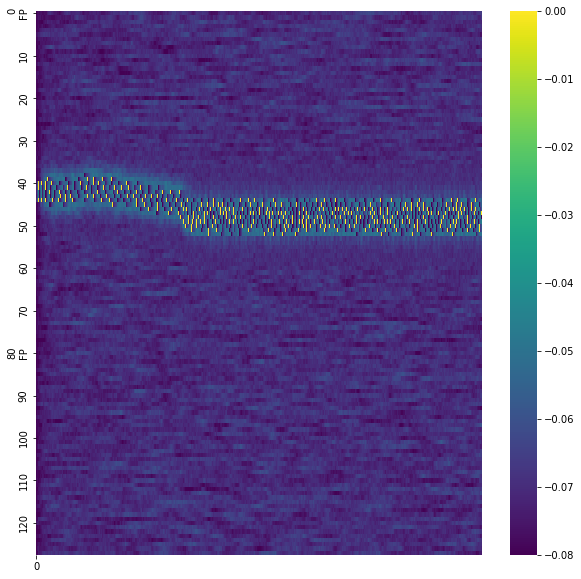

In [213]:
# Plot memebrane potentials of all neurons over time 
fig, ax = plt.subplots(figsize=(10,10))
df = pd.DataFrame(potentials)
sns.heatmap(df, vmin=-0.08, vmax=0.0, cmap="viridis", yticklabels=10, xticklabels=1000)

# Specify fixed point neurons on the y-axis
labels = [item.get_text() for item in ax.get_yticklabels()]

for i, l in enumerate(labels):
    if int(l) in fixed_points:
        labels[i] = labels[i] + '\nFP'

ax.set_yticklabels(labels)

plt.show()

While the basic ring implementation works here, this is subject to specificities of the parameters. We will, at a later stage, explore what parameter range is feasible for the network to function as a ring-attractor that outputs head direction of an animal.